# MTA Turnstile Data Analysis

#### Client Request:
Jon & Julia -

It was great to meet with you and chat at the event where we recently met and had a nice chat. We’d love to take some next steps to see if working together is something that would make sense for both parties.

As we mentioned, we are interested in harnessing the power of data and analytics to optimize the effectiveness of our street team work, which is a significant portion of our fundraising efforts.

WomenTechWomenYes (WTWY) has an annual gala at the beginning of the summer each year. As we are new and inclusive organization, we try to do double duty with the gala both to fill our event space with individuals passionate about increasing the participation of women in technology, and to concurrently build awareness and reach.

To this end we place street teams at entrances to subway stations. The street teams collect email addresses and those who sign up are sent free tickets to our gala.

Where we’d like to solicit your engagement is to use MTA subway data, which as I’m sure you know is available freely from the city, to help us optimize the placement of our street teams, such that we can gather the most signatures, ideally from those who will attend the gala and contribute to our cause.

The ball is in your court now—do you think this is something that would be feasible for your group? From there we can explore what kind of an engagement would make sense for all of us.

Best,

Karrine and Dahlia

WTWY International

In [185]:
# Import Dependencies
from GetDataURLs import GetDataURLs
import csv
from collections import defaultdict
import dateutil.parser
import numpy as np

# For display
import pprint
import matplotlib.pyplot as plt
%matplotlib inline

In [186]:
def download_and_process_raw_data(raw_HTML_data_URLs):
    """
    In: 
    raw_HTML_data_URLs = A .txt file with unparsed HTML code containing the desired URLs to the data
    
    Out:
    raw_data_dict = A dictionary of the raw data with keys as a tuple: ("C/A", "UNIT", "SCP", "STATION - LINENAME")
    """
    
    # Parse raw HTML using regular expressions to get URLs to data files
    link_list = GetDataURLs(raw_HTML_data_URLs)
    
    #Split each URL by "/" and take the last item to the file name and extension without the past (e.g. "data.txt")
    file_list = [link.split("/")[-1] for link in link_list]
    
    raw_data_dict = {}
    
    for link, file in zip(link_list, file_list):
        """
        Download the raw data
        
        To save time do this ONLY ONCE, and then comment out!
        """
        # !curl -O http://web.mta.info/developers/$link

        # Open files from the "data" folder
        with open("./data/" + file) as f:
            reader = csv.reader(f)
            rows = [[cell.strip() for cell in row] for row in reader]

        
        # Check that the data file headers are correct and remove
        assert rows.pop(0) == ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
                           'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES',
                           'EXITS']

        for row in rows:
            # Make key, appending LINENAME to STATION after sorting the characters in LINENAME to ensure consistency
            dict_key = tuple([row[0], row[1], row[2], row[3] + " - " + "".join(sorted([c for c in row[4]]))])
            
            raw_data_dict.setdefault(dict_key, []).append(row[4:])

    return raw_data_dict

raw_data_dict = download_and_process_raw_data("rawHTMLdataURLs.txt")

In [188]:
def raw_dict_to_datetime_and_entries(d):
    """
    In:
    d = raw data dictionary
    
    Out:
    new_dict = new dictionary with date and time strings combined and converted to dateime, 
               and turnstile entries converted from raw total to net new entries (integer)
    """
    new_dict = defaultdict()
    
    for k, lst in d.items():
        
        new_dict[k] = []
        
        for data_row in lst:
            # Find dates and time data points and combine into one
            datetime_str = str(data_row[2]) + " " + str(data_row[3])
            
            # Use dateutil to convert to datetime
            new_date = dateutil.parser.parse(datetime_str)
            
            #Get turnstile entries count and convert to integer
            entries = int(data_row[5])
            
            # Append datetime and entries to new data row list
            new_data_row = []
            new_data_row.append(new_date)
            new_data_row.append(entries)
            
            # Append new data row list to new dict. under the key
            new_dict[k].append(new_data_row)
            
    for k, lst in new_dict.items():
        lst = sorted(lst, key=lambda x: x[0])
        
        for i, data_row in enumerate(lst):
            if i == 0:
                data_row.append(0)
            else:
                data_row.append(lst[i][1] - lst[i-1][1])
            
        for data_row in lst:
            data_row.pop(-2)
    
    return new_dict

processed_dict = raw_dict_to_datetime_and_entries(raw_data_dict)

In [189]:
def remove_entry_count_outliers(d):
    """
    In: 
    d = processed dictionary with net entry counts rather than raw totals
    
    Out: 
    new dictionary removing outliers (negative entries or over 10,000 entries per 4 hours)
    """
    return {turnstile: [(time, count) for (time, count) in rows if 0 <= count <= 10000]
                for turnstile, rows in d.items()}

processed_dict = remove_entry_count_outliers(processed_dict)

In [191]:
def roll_up_by_date(d):
    """
    In:
    d = processed dictionary with net entry counts rather than raw totals and outliers removed
    
    Out:
    new_dict = new dictionary with all the readings within each date combined for each key (turnstile)
    """
    new_dict = defaultdict()
    for k, list_of_lists in d.items():
        sorted_LoL = sorted(list_of_lists)  # Sort so that dates are in order
        
        new_dict[k] = []
        
        last_date = ""
        total = 0
        
        for i, data_list in enumerate(sorted_LoL):
            try:
                date = data_list[0].date()
            except AttributeError:
                date = data_list[0]  # If object is already a date, no need to call .date()
            entries = data_list[1]
            
            if i == 0:
                last_date = date
            
            if date == last_date:
                total += entries
            else:
                new_dict[k].append([last_date, total])
                last_date = date
                total = entries
                
        new_dict[k].append([last_date, total])
                
    return new_dict

grouped_dates_dict = roll_up_by_date(processed_dict)

In [195]:
def roll_up_SCPs(d):
    """
    In:
    d = processed dictionary grouped by date for each turnstile
    
    Out:
    new_dict = dictionary rolling up individual turnstiles to the ("C/A", "UNIT", "STATION - LINENAME") level
    """
    new_dict = defaultdict()
    
    for k, list_of_lists in d.items():
        new_key = tuple(k[:2] + (k[3],))
        try:
            new_dict[new_key] += list_of_lists
        except KeyError:
            # if there is no entry for this key, make one
            new_dict[new_key] = list_of_lists
        
    # Re-combine dates since there will now be multiple instances of each date again given the SCP roll up
    new_dict = roll_up_by_date(new_dict)
    
    return new_dict

SCPs_rolled_dict = roll_up_SCPs(grouped_dates_dict)

In [197]:
def roll_up_to_stations(d):
    """
    In:
    d = processed dictionary grouped by date with rolled up turnstile SCPs
    
    Out:
    new_dict = dictionary rolling up all turnstiles to the STATION - LINENAME" level
    """
    new_dict = defaultdict()
    
    for k, list_of_lists in d.items():
        new_key = k[2]  # "STATION - LINENAME"
        try:
            new_dict[new_key] += list_of_lists
        except KeyError:
            # if there is no entry for this key, make one
            new_dict[new_key] = list_of_lists
        
    # Re-combine dates since there will now be multiple instances of each date again given the roll up
    new_dict = roll_up_by_date(new_dict)
    
    return new_dict

by_station_dict = roll_up_to_stations(SCPs_rolled_dict)

In [203]:
def roll_all_dates_by_stations(d):
    """
    In:
    d = processed dictionary grouped by date with rolled up stations
    
    Out:
    Dictionary with all dates rolled up to a single value for each station
    """
    return {k: sum([lst[1] for lst in LoLs]) for k, LoLs in d.items()}

all_dates_rolled = sorted(roll_all_dates_by_stations(by_station_dict).items(), key=lambda x: x[1], reverse=True)

In [204]:
num_stations = len(all_dates_rolled)  # Needed for later calculation
pprint.pprint(all_dates_rolled)

[('42 ST-GRD CNTRL - 4567S', 12889763),
 ('34 ST-HERALD SQ - BDFMNQR', 10571107),
 ('14 ST-UNION SQ - 456LNQR', 9810467),
 ('42 ST-TIMES SQ - 1237ACENQRS', 9004882),
 ('34 ST-PENN STA - ACE', 7331467),
 ('42 ST-PA BUS TE - 1237ACENQRS', 7112702),
 ('59 ST-COLUMBUS - 1ABCD', 6497312),
 ('FULTON ST - 2345ACJZ', 6022697),
 ('86 ST - 456', 5900495),
 ('MAIN ST - 7', 5302885),
 ('47-50 ST-ROCK - BDFM', 4960247),
 ('34 ST-PENN STA - 123ACE', 4826398),
 ('59 ST - 456NQR', 4475550),
 ('ROOSEVELT AVE - 7EFMR', 4466310),
 ('CANAL ST - 6JNQRZ', 4240878),
 ('W 4 ST-WASH SQ - ABCDEFM', 4026087),
 ('BARCLAYS CENTER - 2345BDNQR', 3801972),
 ('PATH WTC - 1', 3785161),
 ('72 ST - 123', 3734061),
 ('96 ST - 123', 3717276),
 ('LEXINGTON-53 ST - 6EM', 3589261),
 ('JAMAICA CENTER - EJZ', 3584129),
 ('42 ST-BRYANT PK - 7BDFM', 3321911),
 ('JAY ST-METROTEC - ACF', 3299234),
 ('BOROUGH HALL/CT - 2345R', 3223826),
 ('CHAMBERS ST - 23ACE', 3154484),
 ('34 ST-PENN STA - 123', 3060394),
 ('77 ST - 6', 3012295),
 

In [218]:
def combine_all_stations(d):
    """
    In:
    d = dictionary with keys at the station level (days NOT yet rolled into one value)
    
    Out:
    new_dict = new dictionary
    """
    new_dict = {}
    
    for k, list_of_lists in d.items():
        for date, count in list_of_lists:
            try:
                new_dict[date] += count
            except KeyError:
                new_dict[date] = count
                
    return new_dict
            
system_wide_by_date_dict = combine_all_stations(by_station_dict)

In [220]:
def average_by_day_of_week(d):
    """
    In:
    d = dictionary at system wide level with dates as the keys
    
    Out:
    new_dict = new dictionary with keys for each day of the week with average entries for that day as it's value
    """
    new_dict = {}
    for date, count in d.items():
        weekday = date.weekday()
        try:
            new_dict[weekday].append(count)
        except KeyError:
            new_dict[weekday] = [count]
    
    for k, v in new_dict.items():
        new_dict[k] = np.mean(v)
        
    return new_dict

weekday_final = average_by_day_of_week(system_wide_by_date_dict)

In [221]:
def rotate(l, n):
    return l[-n:] + l[:-n]

In [ ]:
def get_by_weekday_plot_data(one_week_list):
    """
    In:
    one_week_list = list of counts corresponding to each weekday Sunday - Saturday
    
    Out:
    (weekydays, counts) = tuple of weekday numbers and counts to plot
    """
    # weekdays = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
    weekdays = [x + 1 for x in range(7)]
    counts = one_week_list
    return weekdays, counts

In [ ]:
def plot_weekly_rainbow_chart(weekly_lists):
    """
    In:
    weekly_lists = list of weekly lists of count of entries (Sunday - Saturday) to be plotted
    
    Out:
    "Rainbow" chart plot
    """
    for week in weekly_lists:
        weekdays, counts = get_by_weekday_plot_data(week)
        plt.plot(weekdays, counts)

[2959952.5714285714,
 5521351.2142857146,
 6012650.4285714282,
 6152397.0,
 6127352.7857142854,
 5815684.6428571427,
 3646971.7142857141]


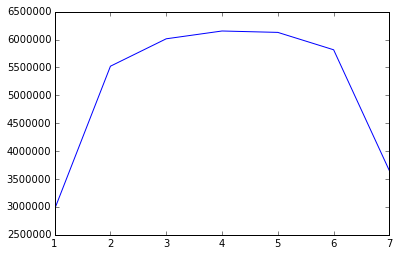

In [222]:
weekly_avgs = [avg for day, avg in sorted(weekday_final.items())]
weekly_avgs = rotate(weekly_avgs, 1)  # Rotate 1 so that Sunday is first day of the week
pprint.pprint(weekly_avgs)
plot_weekly_rainbow_chart([weekly_avgs])

In [212]:
def get_system_wide_weekday_time_of_day_counts(d):
    """
    In:
    d = cleaned and processed dictionary with no turnstiles or dates / times rolled yet
    
    Out:
    new_dict = new dictionary with keys for times of the day and system wide (all stations) entry 
    count for weekdays only
    """
    new_dict = {}
    for turnstile, list_of_lists in d.items():
        for datetime, count in list_of_lists:
            weekday = datetime.weekday()
            time = datetime.time()
            
            if weekday < 5: # If M-F: (5 = Sat, 6 = Sun)
                try:
                    new_dict[time].append(count)
                except KeyError:
                    new_dict[time] = [count]
                    
    return new_dict

time_of_day_counts = get_system_wide_weekday_time_of_day_counts(processed_dict)

In [214]:
def get_system_wide_weekday_time_of_day_avgs(d):
    """
    In:
    d = dictionary with keys for times of the day and system wide (all stations) entry 
    count for weekdays only
    
    Out:
    Dictionary with keys for each weekday time of day and values as the average total entries by station, 
    weekdays only
    """
    return {time: sum(counts)/num_stations for time, counts in d.items() if len(counts) > 100000}

time_of_day_avgs = get_system_wide_weekday_time_of_day_avgs(time_of_day_counts)

In [215]:
pprint.pprint(time_of_day_avgs)

{datetime.time(0, 0): 50963.21199143469,
 datetime.time(1, 0): 21947.982869379015,
 datetime.time(4, 0): 7581.92505353319,
 datetime.time(5, 0): 4031.929336188437,
 datetime.time(8, 0): 67257.49464668095,
 datetime.time(9, 0): 71868.84582441114,
 datetime.time(12, 0): 119772.85653104926,
 datetime.time(13, 0): 56587.850107066384,
 datetime.time(16, 0): 101108.2676659529,
 datetime.time(17, 0): 74397.93361884369,
 datetime.time(20, 0): 154703.5546038544,
 datetime.time(21, 0): 78519.07066381157}


In [216]:
def get_time_of_day_plot_data(d):
    """
    In:
    d = dictionary with keys for each weekday time of day and values as the average total entries by station, 
    weekdays only
    
    Out:
    (times, counts) = tuples of times of day and their respective entry counts for plotting
    """
    times = []
    counts = []
    for time, count in sorted(d.items()):
        times.append(time)
        counts.append(count)
                              
    return times, counts

times, counts = get_time_of_day_plot_data(time_of_day_avgs)

In [ ]:
def plot_time_series(datetimes, counts):
    """
    In:
    datetimes = list of dates and/or times to plot (x-axis values)
    counts = list of counts or other data to plot (y-axis values)
    
    Out:
    Plot of counts by datetime
    """
    plt.figure(figsize=(10,3))
    plt.plot(datetimes, counts)

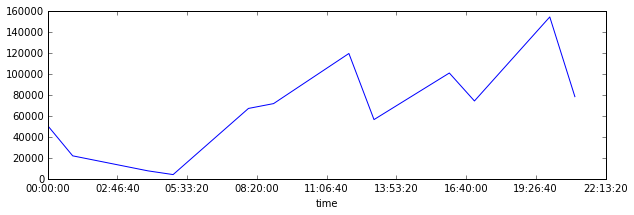

In [217]:
plot_time_series(times, counts)